# Сборный проект

Задача: выявить определяющие успешность игры закономерности. Для исследования предоставленны данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

# 1 Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
df = pd.read_csv('games.csv')

display(df.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведём названия столбцов к нижнему регистру:

In [3]:
df.columns = df.columns.str.lower()

display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Согласно документации к данным:

* `name` — название игры;
* `platform` — платформа;  
* `year_of_release` — год выпуска;
* `genre` — жанр игры;
* `na_sales` — продажи в Северной Америке;
* `eu_sales` — продажи в Европе;
* `jp_sales` — продажи в Японии;
* `other_sales` — продажи в других странах;
* `critic_score` — оценка критиков (максимум 100);
* `user_score` — оценка пользователей (максимум 10);
* `rating` — рейтинг от организации ESRB (англ. Entertainment software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Проверим соответствие типов данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Столбец с оценками пользователей содержит числовые значения но имеет строковый тип, поменяем на соответствующий.
Перед этим провери есть ли ошибочные данные в столбце.

In [5]:
print('Кол-во уникальных значений в столбце user_score:\n', df['user_score'].value_counts())

Кол-во уникальных значений в столбце user_score:
 tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64


Уберём из столбца строки с неверным значением.

In [6]:
df = df.replace('tbd', np.nan) 

df['user_score'] = df['user_score'].astype('float32')
df.info() #проверям замену типа столбца
print()

print('Кол-во пропущенных значений:')
print(df['user_score'].isna().sum())

df['user_score'] = df['user_score'].fillna(df['user_score'].mean())

print('Кол-во пропущенных значений после заполнения средним:')
print(df['user_score'].isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float32
 10  rating           9949 non-null   object 
dtypes: float32(1), float64(6), object(4)
memory usage: 1.3+ MB

Кол-во пропущенных значений:
9125
Кол-во пропущенных значений после заполнения средним:
0


В столбце год выпучка игры находятс целочисленные данные изменим тип данных на корректные, перед этим проверим на наличие пропусков.

In [7]:
print('Кол-во пропущенных строк в столбце year_of_release:\n', df['year_of_release'].isna().sum())

print(df['year_of_release'].isna().sum())

Кол-во пропущенных строк в столбце year_of_release:
 269
269


Так как кол-во пропущенных значений в разы меньше заполненых данных, заменим их на минимальное значение столбца.

In [8]:
df['year_of_release'] = df['year_of_release'].fillna(df['year_of_release'].min())

print(df['year_of_release'].isna().sum())

0


Исправим тип данных в столбце год выпуска на целочисленный.

In [9]:
df['year_of_release'] = df['year_of_release'].astype('int')

df.info()

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16715 non-null  float32
 10  rating           9949 non-null   object 
dtypes: float32(1), float64(5), int32(1), object(4)
memory usage: 1.3+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.000000,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,7.125076,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.300000,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.000000,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,7.125076,NaN


Проверим кол-во пропущенных значений в столбцах critic_score, user_score, rating.

In [10]:
print('critic_score:', df['critic_score'].isnull().sum())
print('user_score:', df['user_score'].isnull().sum())
print('rating', df['rating'].isnull().sum())

critic_score: 8578
user_score: 0
rating 6766


Столбцы в которых хранятся оценки критиков и пользователей можно заполнить средними значениями в этих столбцах.

In [11]:
df['critic_score'] = df['critic_score'].fillna(df['critic_score'].mean())

df['user_score'] = df['user_score'].fillna(df['user_score'].mean())

df['rating'] = df['rating'].fillna('unrated')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  float64
 9   user_score       16715 non-null  float32
 10  rating           16715 non-null  object 
dtypes: float32(1), float64(5), int32(1), object(4)
memory usage: 1.3+ MB


Заполнил пропуски в столбце rating специальным значением для дальнейшего анализа.

## 1.1 Продажи в регионах

Суммируем продвжи во всех регионах.

In [12]:
print('Северная Америка:', df['na_sales'].sum())
print('Европа:', df['eu_sales'].sum())
print('Япония:', df['jp_sales'].sum())

Северная Америка: 4402.35
Европа: 2424.67
Япония: 1297.37


Можно сделать вывод что больше проданных копий игр в Америке, меньше всего в Японии.

# 2 Исследовательский анализ

Изучим сколько игр выпускалось в разные годы, для этого построим гистограмму.

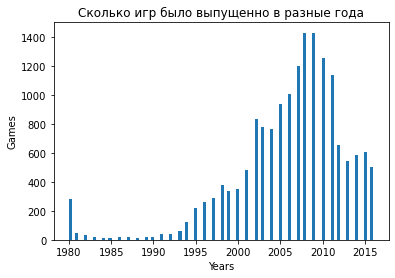

In [13]:
pd.Series(df['year_of_release']).plot(kind = 'hist', bins = 100)
plt.xlabel("Years")
plt.ylabel("Games")
plt.title('Сколько игр было выпущенно в разные года')
plt.show()

Исходя из полученного графика можно сделать вывод, что для дальнейшего исследования следует использовать не все данные, так как кол-во выпускаемых игр сильно менялось на протяжении нескольких десятков лет и только начиная с 200 годов начался равномерный рост. Я считаю, что данные до 2000 года можно не использовать, так как они могут оказать большое влияние на результат исследования.

## 2.1 Как менялись продажи по платформам

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

In [14]:
df_two = df.copy()

df_two['sales_all'] = df_two['na_sales'] + df_two['eu_sales'] + df_two['jp_sales'] + df_two['other_sales']

display(df_two.head())

display(df_two.groupby('platform')['sales_all'].sum().sort_values(ascending = False))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.000000,8.000000,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,68.967679,7.125076,unrated,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.000000,8.300000,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.000000,8.000000,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,68.967679,7.125076,unrated,31.38


platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       30.77
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: sales_all, dtype: float64

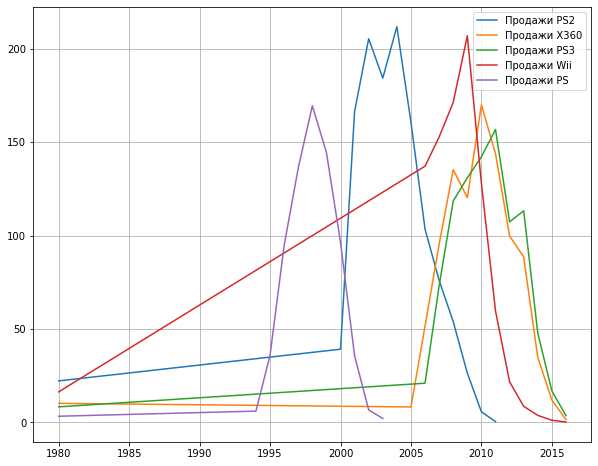

In [15]:
ps2_sales_years = df_two.loc[df['platform'] == 'PS2'].sort_values('year_of_release')
ps2_sales_years_two = ps2_sales_years.pivot_table(index = ['year_of_release'], values = ['sales_all'], aggfunc = 'sum')

x360_sales_years = df_two.loc[df['platform'] == 'X360'].sort_values('year_of_release')
x360_sales_years_two = x360_sales_years.pivot_table(index = ['year_of_release'], values = ['sales_all'], aggfunc = 'sum')

ps3_sales_years = df_two.loc[df['platform'] == 'PS3'].sort_values('year_of_release')
ps3_sales_years_two = ps3_sales_years.pivot_table(index = ['year_of_release'], values = ['sales_all'], aggfunc = 'sum')

wii_sales_years = df_two.loc[df['platform'] == 'Wii'].sort_values('year_of_release')
wii_sales_years_two = wii_sales_years.pivot_table(index = ['year_of_release'], values = ['sales_all'], aggfunc = 'sum')

ps_sales_years = df_two.loc[df['platform'] == 'PS'].sort_values('year_of_release')
ps_sales_years_two = ps_sales_years.pivot_table(index = ['year_of_release'], values = ['sales_all'], aggfunc = 'sum')


plt.figure(figsize = (10,8))
plt.plot(ps2_sales_years_two, label = "Продажи PS2")
plt.plot(x360_sales_years_two, label = "Продажи X360")
plt.plot(ps3_sales_years_two, label = "Продажи PS3")
plt.plot(wii_sales_years_two, label = "Продажи Wii")
plt.plot(ps_sales_years_two, label = "Продажи PS")
plt.legend()
plt.grid()
plt.show()

На получившемся графике можно заметить закономерность, что в среднем одна консоль существует на рынке от 5 до 10 лет, после этого времени её продажи снижаются к минимальным значениям.

## 2.2 Выбор данных за соответствующий актуальный период для аналиа

 Чтобы построить прогноз на 2017 год, следует взть данные за последние 3 года продаж игровых консолей (с 2014 по 2016).

In [16]:
df_two = df_two.loc[df_two['year_of_release'] > 2013]

df_two = df_two.reset_index(drop = True)

display(df_two.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,68.967679,7.125076,unrated,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.000000,8.300000,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,68.967679,7.125076,unrated,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.000000,4.300000,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,68.967679,7.125076,unrated,7.98


## 2.3 Выбор потенциально прибыльных платформ 

Платформы с потенциальной прибылью.

In [17]:
df_three = df_two.loc[(df_two['platform'] == 'PS3') | (df_two['platform'] == 'X360') | (df_two['platform'] == 'PS2') | (df_two['platform'] == 'Wii') | (df_two['platform'] == 'PS')]

df_three = df_three.reset_index(drop = True)

display(df_three.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
0,Minecraft,PS3,2014,Misc,2.03,2.37,0.00,0.87,68.967679,7.125076,unrated,5.27
1,Call of Duty: Advanced Warfare,PS3,2014,Shooter,1.56,1.93,0.19,0.68,68.967679,4.800000,M,4.36
2,Call of Duty: Advanced Warfare,X360,2014,Shooter,2.77,1.11,0.00,0.40,68.967679,4.900000,M,4.28
3,FIFA 15,PS3,2014,Sports,0.58,3.02,0.04,0.64,68.967679,4.500000,E,4.28
4,FIFA 15,X360,2014,Sports,0.79,1.92,0.00,0.21,68.967679,4.200000,E,2.92


Глобальные продажи игр по платформам

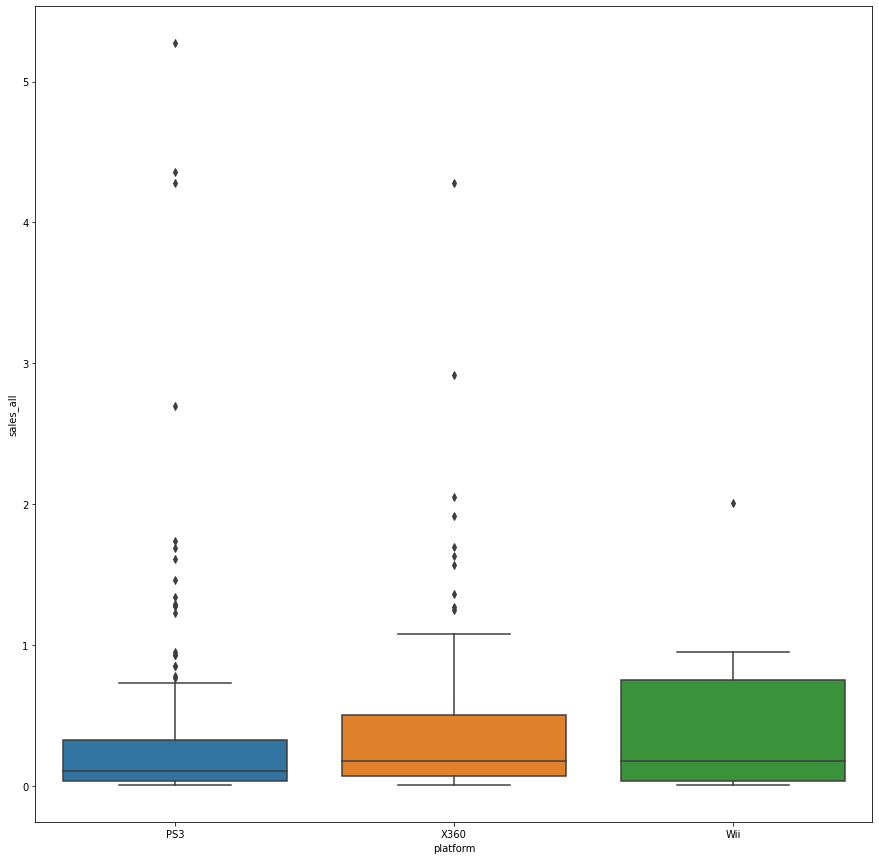

In [18]:
plt.figure(figsize=(15, 15))

sns.boxplot(data = df_three, y = 'sales_all', x='platform')

plt.show()

## 2.4 Влияние отзывов пользователей и критиков на продажи платформы PS3

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

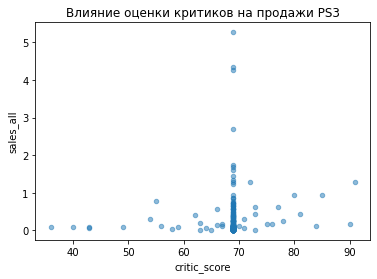

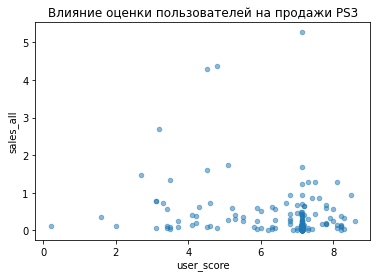

Коэффициент корреляции оценки критиков и кол-ва продаж платформы:
0.09609176862597452

Коэффициент корреляции оценки пользователей и кол-ва продаж платформы:
-0.22212281355851057


In [19]:
df_ps3 = df_two.loc[df_two['platform'] == 'PS3']

df_ps3 = df_ps3.reset_index(drop = True)

df_ps3.plot(x = 'critic_score', y = 'sales_all', kind = 'scatter', alpha = 0.5)
plt.title('Влияние оценки критиков на продажи PS3')
plt.show()

df_ps3.plot(x = 'user_score', y = 'sales_all', kind = 'scatter', alpha = 0.5)
plt.title('Влияние оценки пользователей на продажи PS3')
plt.show()

print('Коэффициент корреляции оценки критиков и кол-ва продаж платформы:')
print(df_ps3['critic_score'].corr(df_ps3['sales_all']))
print()

print('Коэффициент корреляции оценки пользователей и кол-ва продаж платформы:')
print(df_ps3['user_score'].corr(df_ps3['sales_all']))

Из диаграмм рассеяния можно увидеть, что больше всего на кол-во продаж влияет оценка критиков (чем выше оценка критика, тем больше продажи платформы). Коэффициен корреляции показывает что связь между оценкой критиков и продажами есть но она не сильная, значит отзыв критиков не всегда сопровождаетс ростом продаж. Корреляция между оценкой пользователй и продажами очень слабая, их оценки практически не влияют на продажи.

Проверим влияние оценки пользователй и критиков на продажи других платформ.

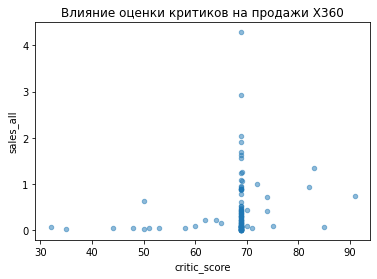

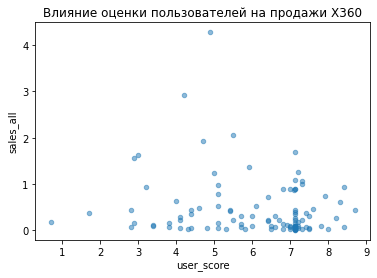

Коэффициент корреляции оценки критиков и кол-ва продаж платформы:
0.17593527130003558

Коэффициент корреляции оценки пользователей и кол-ва продаж платформы:
-0.1790292465325503


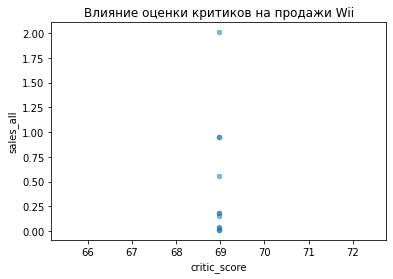

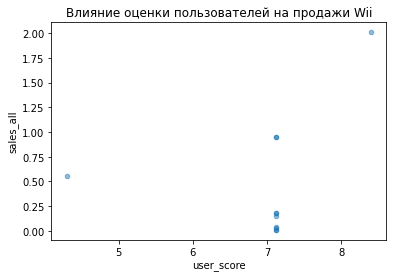

Коэффициент корреляции оценки критиков и кол-ва продаж платформы:
nan

Коэффициент корреляции оценки пользователей и кол-ва продаж платформы:
0.27970335335499535


In [20]:
df_x360 = df_two.loc[df_two['platform'] == 'X360']
df_x360 = df_x360.reset_index(drop = True)

df_x360.plot(x = 'critic_score', y = 'sales_all', kind = 'scatter', alpha = 0.5)
plt.title('Влияние оценки критиков на продажи X360')
plt.show()

df_x360.plot(x = 'user_score', y = 'sales_all', kind = 'scatter', alpha = 0.5)
plt.title('Влияние оценки пользователей на продажи X360')
plt.show()

print('Коэффициент корреляции оценки критиков и кол-ва продаж платформы:')
print(df_x360['critic_score'].corr(df_x360['sales_all']))
print()

print('Коэффициент корреляции оценки пользователей и кол-ва продаж платформы:')
print(df_x360['user_score'].corr(df_x360['sales_all']))



df_wii = df_two.loc[df_two['platform'] == 'Wii']
df_wii = df_wii.reset_index(drop = True)

df_wii.plot(x = 'critic_score', y = 'sales_all', kind = 'scatter', alpha = 0.5)
plt.title('Влияние оценки критиков на продажи Wii')
plt.show()

df_wii.plot(x = 'user_score', y = 'sales_all', kind = 'scatter', alpha = 0.5)
plt.title('Влияние оценки пользователей на продажи Wii')
plt.show()

print('Коэффициент корреляции оценки критиков и кол-ва продаж платформы:')
print(df_wii['critic_score'].corr(df_wii['sales_all']))
print()

print('Коэффициент корреляции оценки пользователей и кол-ва продаж платформы:')
print(df_wii['user_score'].corr(df_wii['sales_all']))

## 2.5 Общее распределение игр по жанрам

Построим гистограмму отражающую кол-во продаж игр по жанрам.

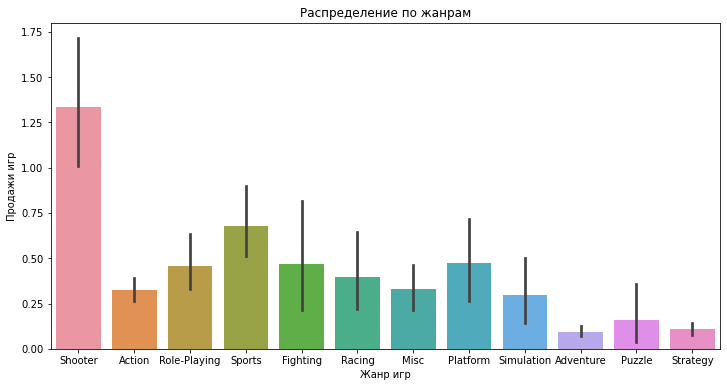

In [21]:
plt.figure(figsize = (12, 6))
plt.title('Распределение по жанрам')
sns.barplot(data = df_two, x = 'genre', y = 'sales_all')
plt.xlabel('Жанр игр')
plt.ylabel('Продажи игр')
plt.show()

По гистограмме распределения игр можно сделать вывод, что игры жанра шутер и платформер имеют самыое большое кол-во продаж среди всех жанров. Игры жанра приключения и стратегии имеют самые низкие показатели продаж.

# 3 Портрет пользователя каждого региона

Определим самые популярные платформы для различных стран.

In [22]:
na_sales = df_two.pivot_table(index = ['platform'], values = ['na_sales'], aggfunc = 'sum')
na_sales = na_sales.sort_values(by = 'na_sales', ascending = False)
print('Самые популярные платформы в Северной Америке:')
display(na_sales.head())

eu_sales = df_two.pivot_table(index = ['platform'], values = ['eu_sales'], aggfunc = 'sum')
eu_sales = eu_sales.sort_values(by = 'eu_sales', ascending = False)
print('Самые популярные платформы в Европе:')
display(eu_sales.head())

jp_sales = df_two.pivot_table(index = ['platform'], values = ['jp_sales'], aggfunc = 'sum')
jp_sales = jp_sales.sort_values(by = 'jp_sales', ascending = False)
print('Самые популярные платформы в Японии:')
display(jp_sales.head())

Самые популярные платформы в Северной Америке:


,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


Самые популярные платформы в Европе:


,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


Самые популярные платформы в Японии:


,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


Определим самые популярные жанры в различных странах.

In [35]:

na_genre = df_two.pivot_table(index = ['genre'], values = ['na_sales'], aggfunc = 'sum')
na_genre = na_genre.sort_values(by = 'na_sales', ascending = False)
print('Самые популярные жанры игр в Северной Америке:')
display(na_genre.head())

eu_genre = df_two.pivot_table(index = ['genre'], values = ['eu_sales'], aggfunc = 'sum')
eu_genre = eu_genre.sort_values(by = 'eu_sales', ascending = False)
print('Самые популярные жанры игр в Европе:')
display(eu_genre.head())

jp_genre = df_two.pivot_table(index = ['genre'], values = ['jp_sales'], aggfunc = 'sum')
jp_genre = jp_genre.sort_values(by = 'jp_sales', ascending = False)
print('Самые популярные платформы в Японии:')
display(jp_genre.head())

Самые популярные жанры игр в Северной Америке:


,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


Самые популярные жанры игр в Европе:


,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


Самые популярные платформы в Японии:


,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


Определим влияние рейтинга организации ESRB на продажи платформ.

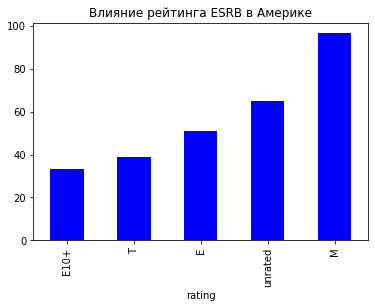

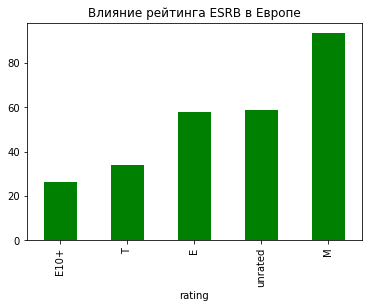

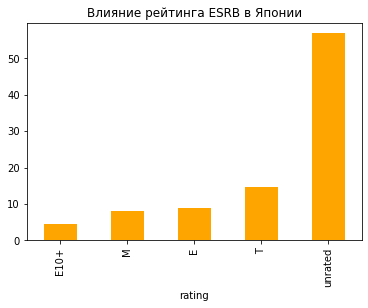

In [43]:
na_esrb_rating = df_two.groupby('rating')['na_sales'].sum().sort_values()
eu_esrb_rating = df_two.groupby('rating')['eu_sales'].sum().sort_values()
jp_esrb_rating = df_two.groupby('rating')['jp_sales'].sum().sort_values()

na_esrb_rating.plot(kind = 'bar', color = 'blue')
plt.title('Влияние рейтинга ESRB в Америке')
plt.show()

eu_esrb_rating.plot(kind = 'bar', color = 'green')
plt.title('Влияние рейтинга ESRB в Европе')
plt.show()

jp_esrb_rating.plot(kind = 'bar', color = 'orange')
plt.title('Влияние рейтинга ESRB в Японии')
plt.show()

Портрет пользователя из Северной Америки:

Покупает платформу X360 или PS3 (вероятнее X360), играет в игры с жанарами Action или Shooter.

Портрет пользователя из Европы:
    
Покупает платформу PS3 или X360, играет в игры с жанрами Action или Shooter.

Портрет пользователя из Японии:
    
Покупает платформу 3DS или DS, играет в игры с жанрами Role-Playing или Action.

Влияние оценки ESRB можно увидеть во всех странах, можно выделить Северную америку и Европу где оценка E (для всех возрастов) сильно повышает продажи игр, по сравнению с играми имеющими другие рейтинги.

# 4 Проверка гипотез

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, проверим эту гипотезу.

H_0: Рейтинг платформы Xbox One = рейтинг платформы PC.

H_1: Рейтинг платформы Xbox One ≠ рейтинг платформы PC.

In [25]:
df_two['platform'].value_counts()

PS4     376
PSV     295
XOne    228
PS3     219
3DS     212
PC      151
X360    111
WiiU     73
PSP      13
Wii      11
Name: platform, dtype: int64

In [46]:
results = st.ttest_ind(df_two[df_two['platform'] == 'XOne']['user_score'],
                      df_two[df_two['platform'] == 'PC']['user_score'], equal_var = False)

alpha = 0.1

print(results.pvalue)

if results.pvalue < alpha:
    print('отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.0591033491415189
отвергаем нулевую гипотезу


Средние пользовательские рейтинги жанров Action и Sports разные, проверим гипотезу.

H_0: Рейтинги жанра Action = рейтинги жанра Sports.

H_1: Рейтинги жанра Action ≠ рейтинги жанра Sports.

In [45]:
results_two = st.ttest_ind(df_two[df_two['genre'] == 'Action']['user_score'],
                      df_two[df_two['genre'] == 'Sports']['user_score'], equal_var = False)

alpha = 0.1

print(results_two.pvalue)

if results_two.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

5.324200880089711e-16
Отвергаем нулевую гипотезу


Сделав t-тест можно сделать вывод, что первая гипотеза имеет место быть и отвергать её точно не стоит. Во втором тесте вероятность получить предполагаемый результат очень мала, значит нулевую гипотезу можно отвергнуть.

**Я доконца не разобрался как правильно выбирать уровень значимости, в данном пункте руководствовался теорией, но там нет подробного объяснения.**

# 5 Общий вывод

Для исследования интернет-магазина был предоставлен файл с информацией о продажах различных игровых платформ. Перед исследованием я провёл предобработку данных, изменил регистр названий столбцов на нижний, преобразовал столбцы в соответсвующие с их информацией типы, перед этим обработав пропуски в столбцах. Далее я рассмотрел изменение продаж платформ на протяжении нескольких дестков лет и вывел закономерность, что в среднем одна платформа находит покупателей от 5 до 10 лет. Взяв актуальный период (от 2008 до 2016 года) я проанализировал какие платфрмы занимают лидирующие позиции на рынке продаж (сделал запрос на использование в дальнейшем исследовании только конкретные платформы). Используя оценки критиков на популярные платформы, сделал вывод что они имеют влиние на рост продаж (не сильное влияние), но он есть по сравнению с оценками пользователей. Изучив распределение игр по жанрам выделил наиболее прибыльные жанры Pltatform и Shooter, самые убыточные жанры, это Strategy и Adventure. Выделив сымые популярные платформы и самые популярные жанры игр в различных странах составил портреты пользователй в этих странах. Так же сделал выод, что система рейтнга ESRB влияет на продажи платформ по разному в разных стрнах, например при продпже платформ в Америке и Европе для получения прибыли можно ориентироваться на оценку ESRB.